# Forward Model Testing Notebook
### Thomas Ales | July 2020

#### CHANGELOG:  
0 - Initial Version

In [2]:
# Imports
# Numpy, Sympy and Matplotlib
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

In [5]:
plt.style.use('seaborn-colorblind') # hmm...

### Materials

In [282]:
# (1) Li, Wenqi | Laser ultrasonic method for determination of crystallographic orientation
# of large grain metals by spatially resolved acoustic spectroscopy | PhD Thesis
# University of Nottingham. http://eprints.nottingham.ac.uk/12391/2/thesis.pdf

# a-Titanium (1)
alpha_Ti = {
    "symmetry": "hexagonal",
    "constants": {              # Crystal constants in GPa
        "c11": 163.6,
        "c12": 92.30,
        "c13": 67.92,
        "c33": 185.2,
        "c44": 47.05 },
    "density": 4.429            # material density g/cm3
    }

# Polycrystalline Silicon (1)
poly_Si = {
    "symmetry": "cubic",
    "constants": {
        "c11": 165.0,
        "c12": 64.00,
        "c44": 79.20
    },         
    "density": 2.328            # material density, g/cm3
}


### Class Prototype

In [316]:
class SAWModel():

    def __init__(self, _matl):

        self.material = _matl
        self.mvec = []
        self.nvec = []
        self.rotation_matrix = []
        self.matden = self.material["density"]
        self.cijkl = np.ndarray(shape=(6,6))
        return

    def set_rotmat_euler(self, _eangl):
        '''
            set_rotmat_euler(_eangl=()): Convert a tuple (0.0, 0.0, 0.0) of Euler angles to the corresponding rotation matrix.
                                          Expects RADIANS for angles. Wrap tuple with numpy.radians(_eangl) if tuple is in degrees.
        '''
        # setup rotation matrix as list of lists
        _rotmatl = [[np.cos(_eangl[0])*np.cos(_eangl[2]) - np.cos(_eangl[1])*np.sin(_eangl[0])*np.sin(_eangl[2]), 
                 -np.cos(_eangl[0])*np.sin(_eangl[2]), np.sin(_eangl[0])*np.sin(_eangl[1])],
                 [np.cos(_eangl[2])*np.sin(_eangl[0]) + np.cos(_eangl[0])*np.cos(_eangl[1])*np.sin(_eangl[2]),
                  np.cos(_eangl[0])*np.cos(_eangl[1])*np.cos(_eangl[2]) - np.sin(_eangl[0])*np.sin(_eangl[2]),
                  -np.cos(_eangl[0])*np.sin(_eangl[1])], [np.sin(_eangl[1])*np.sin(_eangl[2]), 
                  np.cos(_eangl[2])*np.sin(_eangl[1]), np.cos(_eangl[1])]]
        # convert to numpy ndarray
        _rotmatn = np.ndarray(shape=(3,3))
        _rotmatn[:] = _rotmatl
        self.rotation_matrix = _rotmatn
        # extract m, n vectors and set as class properties
        self.mvec = np.array([_rotmatn[0,0], _rotmatn[1,0], _rotmatn[2,0]])
        self.mvec = np.around(self.mvec, decimals=4)
        self.nvec = np.array([_rotmatn[0,2], _rotmatn[1,2], _rotmatn[2,2]])
        self.nvec = np.around(self.nvec, decimals=4)
        return 

    def construct_cijkl(self):
        # Hexagonal symmetry case
        if(self.material["symmetry"] == "hexagonal"):
            print("Hexagonal Symmetry Mode.")
            # import material data
            self.cijkl[0,0] = self.material["constants"]["c11"]
            self.cijkl[0,1] = self.material["constants"]["c12"]
            self.cijkl[0,2] = self.material["constants"]["c13"]
            self.cijkl[2,2] = self.material["constants"]["c33"]
            self.cijkl[3,3] = self.material["constants"]["c44"]
            # apply crystal symmetry to the rest of Cijkl                      
            # row 2 symmetry
            self.cijkl[1,0]  = self.cijkl[0,1]
            self.cijkl[1,1] = self.cijkl[0,0]
            self.cijkl[1,2] = self.cijkl[0,2]
            # row 3 symmetry
            self.cijkl[2,0] = self.cijkl[2,1] = self.cijkl[0,2]
            # rest                        
            self.cijkl[4,4] = self.cijkl[3,3]
            self.cijkl[5,5] = 2.0*(self.cijkl[0,0] - self.cijkl[0,1])
            

        # Cubic symmetry case
        elif(self.material["symmetry"] == "cubic"):
            print("Cubic Symmetry Mode.")
            # import material data
            self.cijkl[0,0] = self.material["constants"]["c11"]
            self.cijkl[0,1] = self.material["constants"]["c12"]
            self.cijkl[3,3] = self.material["constants"]["c44"]

            # apply crystal symmetry to rest of cijkl
            self.cijkl[0,2] = self.cijkl[1,0] = self.cijkl[1,2] = self.cijkl[2,0] = self.cijkl[2,1] = self.cijkl[0,1]
            self.cijkl[4,4] = self.cijkl[5,5] = self.cijkl[3,3]

        return

    def solve_gamma_matrix(self, _vel):
        l1 = self.mvec[0]
        l2 = self.mvec[1]
        l3 = self.mvec[2]
        if(self.material["symmetry"] == "hexagonal"):
            g11 = self.cijkl[0,0]*(l1**2) + self.cijkl[5,5]*(l2**2) + self.cijkl[3,3]*(l3**2)
            g22 = self.cijkl[5,5]*(l1**2) + self.cijkl[0,0]*(l2**2) + self.cijkl[3,3]*(l3**2)
            g33 = self.cijkl[3,3]*(l1**2) + self.cijkl[3,3]*(l2**2) + self.cijkl[2,2]*(l3**2)
            g12 = (self.cijkl[0,2] + self.cijkl[3,3])*l2*l3
            g13 = (self.cijkl[0,2] + self.cijkl[3,3])*l1*l3
            g23 = (self.cijkl[0,0] - self.cijkl[5,5])*l1*l2
        
        elif(self.material["symmetry"] == "cubic"):
            g11 = self.cijkl[0,0]*(l1**2) + self.cijkl[3,3]*(l2**2) + self.cijkl[3,3]*(l3**2)
            g22 = self.cijkl[3,3]*(l1**2) + self.cijkl[0,0]*(l2**2) + self.cijkl[3,3]*(l3**2)
            g33 = self.cijkl[3,3]*(l1**2) + self.cijkl[3,3]*(l2**2) + self.cijkl[0,0]*(l3**2)
            g12 = (self.cijkl[1,3] + self.cijkl[3,3])*l2*l3
            g13 = (self.cijkl[1,3] + self.cijkl[3,3])*l1*l3
            g23 = (self.cijkl[1,3] + self.cijkl[3,3])*l1*l2

        gamma_mtx = sym.Matrix([[g11 - float(self.material['density'])*(_vel**2), g12, g13],
                                [g12, g22 - float(self.material['density'])*(_vel**2), g23],
                                [g13, g23, g33 - float(self.material['density'])*(_vel**2)]])
        return _vel, gamma_mtx.det(method="lu")


In [317]:
sawtest = SAWModel(alpha_Ti)
sawtest.set_rotmat_euler(np.radians((0.0, 50.0, 0.0)))
print("INPUT VECTOR:")
print("m: {0:.4f} {1:.4f} {2:.4f}, n: {3:.4f} {4:.4f} {5:.4f}".format(sawtest.mvec[0], sawtest.mvec[1], sawtest.mvec[2], sawtest.nvec[0], sawtest.nvec[1], sawtest.nvec[2]))

sawtest.construct_cijkl()
print("Cijkl MATRIX:")
print(sawtest.cijkl)

speed, deter = sawtest.solve_gamma_matrix(3.259315)
print("Det is {0:.4f} for speed {1:.4f} m/s.".format(
    deter, speed
))

INPUT VECTOR:
m: 1.0000 0.0000 0.0000, n: 0.0000 -0.7660 0.6428
Hexagonal Symmetry Mode.
Cijkl MATRIX:
[[163.6   92.3   67.92   0.     0.     0.  ]
 [ 92.3  163.6   67.92   0.     0.     0.  ]
 [ 67.92  67.92 185.2    0.     0.     0.  ]
 [  0.     0.     0.    47.05   0.     0.  ]
 [  0.     0.     0.     0.    47.05   0.  ]
 [  0.     0.     0.     0.     0.   142.6 ]]
Det is 1.5404 for speed 3.2593 m/s.


In [318]:
print(sawtest.rotation_matrix)
sawtest.mvec = np.array([sawtest.rotation_matrix[0,0], sawtest.rotation_matrix[1,0], sawtest.rotation_matrix[2,0]])
sawtest.mvec = np.around(sawtest.mvec, decimals=4)
sawtest.nvec = np.array([sawtest.rotation_matrix[0,2], sawtest.rotation_matrix[1,2], sawtest.rotation_matrix[2,2]])
sawtest.nvec = np.around(sawtest.nvec, decimals=4)
print(sawtest.mvec)
print(sawtest.nvec)

[[ 1.         -0.          0.        ]
 [ 0.          0.64278761 -0.76604444]
 [ 0.          0.76604444  0.64278761]]
[1. 0. 0.]
[ 0.     -0.766   0.6428]


In [319]:
dets = []
results = []
sawtest = SAWModel(alpha_Ti)
sawtest.construct_cijkl()
for angle in range(0, 181, 1):
    sawtest.set_rotmat_euler(np.radians((0, angle, 0.0)))
    _ang, _d  = sawtest.solve_gamma_matrix(3.259315)
    results.append(_d)
results = np.array(results)

Hexagonal Symmetry Mode.


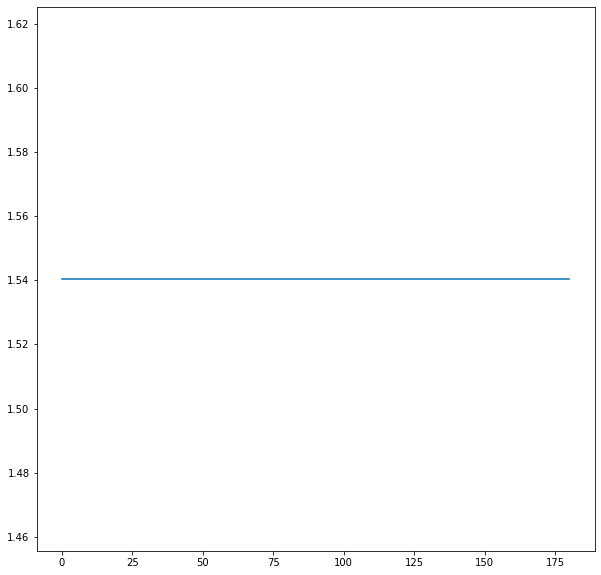

In [320]:
plt.figure(figsize=[10, 10])
plt.plot([x for x in range(0,181, 1)], results)

In [352]:
smodel = SAWModel(poly_Si)
smodel.construct_cijkl()
smodel.set_rotmat_euler((0.0, 0.0, 0.0))
dets = []
speeds = []

for v in range(2500, 6000, 10):
    _spd = v / 1000.0 
    dets.append(smodel.solve_gamma_matrix(_spd)[1])
    speeds.append(v)

Cubic Symmetry Mode.


(250, 350)

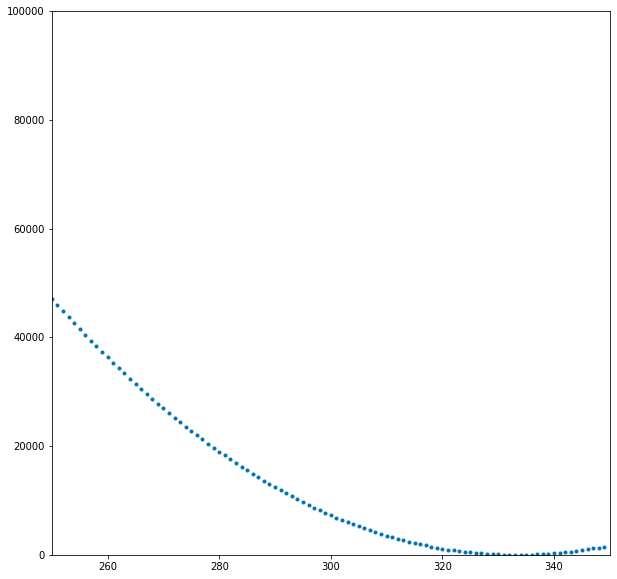

In [354]:
plt.figure(figsize=[10,10])
plt.plot(dets, '.')
plt.ylim([0, 1E5])
plt.xlim([250, 350])